In [3]:
import numpy as np
import pandas as pd
import time
import cv2
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from pyntcloud import PyntCloud as pc
from tqdm import tqdm_notebook as tqdm

Imports from my own libraries

In [4]:
from Kinect import Kinect
from Planes import find_plane, distance_from_plane
from watershed import watershed

Grab a pointcloud from the Kinect

In [5]:
k = Kinect(debug=True)
k.start()
k.wait_for_init()
point_cloud = k.get_pointcloud()
k.stop()

Packet pipeline: OpenCLPacketPipeline
Number of devices: 1
Init done
Stopping device
Closing device
Device stopped and closed


Display the pointcloud using Pyntcloud

In [6]:
points = pd.DataFrame(point_cloud, columns=['x', 'y', 'z', 'red', 'green', 'blue'])
cloud = pc(points)
cloud.plot(IFrame_shape=(1200, 700), point_size=0.001)

A method for getting 3 random points from a set of points

In [12]:
def get_rand_points(points):
    
    r = np.random.choice(range(len(points)), 3)
    p = points[r]

    return p

A method for getting the difference between two multidimensional arrays

In [7]:
# from: https://stackoverflow.com/a/9271260/6588972
def multidim_diff(arr1, arr2):
    arr1_view = arr1.view([('',arr1.dtype)]*arr1.shape[1])
    arr2_view = arr2.view([('',arr2.dtype)]*arr2.shape[1])
    diff = np.setdiff1d(arr1_view, arr2_view)
    return diff.view(arr1.dtype).reshape(-1, arr1.shape[1])

Our planes are of the form $ax+by+cz=d$, but we fit to the form $ax+by+c=z$ in order to solve $Ax=B$.<br>
Where $
\mathbf{A} = 
    \begin{vmatrix}
        x_1 & y_1 & 1 \\
        x_2 & y_2 & 1 \\
        \vdots & \vdots & \vdots \\
        x_n & y_n & 1
    \end{vmatrix}
$, 
$
x = \begin{vmatrix}
        a \\
        b \\
        c
    \end{vmatrix}
$ and
$
\mathbf(B) = 
    \begin{vmatrix}
    z_1 \\
    z_2 \\
    \vdots \\
    z_n
    \end{vmatrix}
$ <br><br>
The following method fits the plane, and converts the parameters to the form we need.

In [8]:
def fit_plane_to_points(points, plane_params):
    M = np.zeros(points.shape)
    M[:,:2] = points[:,:2]
    M[:,2] = 1
    z = np.zeros((points.shape[0], 1))
    z = points[:,2]
    
    p, res, rnk, s = lstsq(M, z)
    #print(p)
    
    a = plane_params[0]
    b = plane_params[1]
    c = plane_params[2]
    d = plane_params[3]
    
    fit_a = -p[0] * c
    fit_b = -p[1] * c
    fit_c = c
    fit_d = -p[2] * c

    return fit_a, fit_b, fit_c, fit_d

In [9]:
def do_ransac(points, mask_on_points, limit, iterations=50):
    """
    points: all points in the cloud
    mask_on_points: 1d array of bool values, true value indicates point can be evaluated on
    limit: distance limit for ransac
    iterations: iterations for ransac
    """
    best_fit = {"num": 0,
                "inliers": None,
                "plane": None,
                "dists": None,
                "mask": None}
    
    # Get valid points, based on mask
    valid_points = points[mask_on_points]
    
    for i in tqdm(range(iterations)):
        p1, p2, p3 = get_rand_points(valid_points)

        p_a, p_b, p_c, p_d = find_plane(p1, p2, p3)
        
        # Find number of inliers
        dists = distance_from_plane(valid_points, p_a, p_b, p_c, p_d)
        inliers = valid_points[dists<limit]
        
        # If number of inliers is highest yet
        if inliers.shape[0] > best_fit["num"]:
            # Fit a new plane to these inliers
            fit_params = fit_plane_to_points(inliers, (p_a, p_b, p_c, p_d))
            
            # Get all distances to this new plane
            fit_dists = distance_from_plane(points, *fit_params)
            
            #fit_inliers = points[fit_dists<limit]
            # Get a mask, True where distance is less than limit
            fit_inliers = fit_dists < limit
            fit_inliers = np.logical_and(fit_inliers, mask_on_points)
            
            # Get a mask of outliers
            fit_outliers = np.logical_not(fit_inliers)
            
            # Mask of valid points, if this fit is used
            new_mask = np.logical_and(mask_on_points, fit_outliers)
            
            best_fit["num"] = inliers.shape[0]
            best_fit["inliers"] = fit_inliers
            best_fit["plane"] = fit_params
            best_fit["dists"] = fit_dists
            best_fit["mask"] = new_mask
    
    return best_fit

In [10]:
def find_planes(point_cloud, limit=0.1, ransac_iterations=50, stop_at=3):
    planes = []
    
    ps = point_cloud[:,:3]
    #all_ps = point_cloud[:,:3]
    mask = np.ones(ps.shape[0], dtype=np.bool)
    
    while(ps.shape[0] > 10000):
        fit = do_ransac(ps, mask, limit, ransac_iterations)
        planes.append(fit)
        mask = fit["mask"]
        
        #ps = multidim_diff(np.ascontiguousarray(ps), np.ascontiguousarray(fit["inliers"]))
        
        if len(planes) == stop_at:
            break
    
    return planes

Perform RANSAC

In [13]:
std_limit = np.std(point_cloud[:,:3]) / 20
print("std limit: {}".format(std_limit))
planes = find_planes(point_cloud, limit=std_limit, ransac_iterations=100, stop_at=3)

std limit: 0.2559883362982996


In [14]:
print("Planes found: {}".format(len(planes)))

Planes found: 3


Color a pointcloud with the points in planes, for visualization

In [15]:
pc_show = np.copy(point_cloud)

np.putmask(pc_show[:,5], planes[0]["inliers"], 255.0)
np.putmask(pc_show[:,4], planes[1]["inliers"], 255.0)
np.putmask(pc_show[:,3], planes[2]["inliers"], 255.0)

Show the planes

In [16]:
points = pd.DataFrame(pc_show, columns=['x', 'y', 'z', 'red', 'green', 'blue'])
#points.describe()
cloud = pc(points)
cloud.plot(IFrame_shape=(1200, 700), point_size=0.001)

- Points needs to be continous
- Points needs to be white
- Bounding box must be found

Try converting one plane to an image, so we can use various methods for images on it.

In [17]:
p_plane = point_cloud[planes[0]["inliers"]]
x_max = np.max(p_plane[:,0])
x_min = np.min(p_plane[:,0])
y_max = np.max(p_plane[:,1])
y_min = np.min(p_plane[:,1])

print("Max x: {}, min x: {}".format(x_max, x_min))
print("Max y: {}, min y: {}".format(y_max, y_min))

Max x: 7.44344035557809, min x: -5.141657034799137
Max y: 3.5005144384541333, min y: -6.224967064189339


In [18]:
p_plane[:,0] -= x_min
p_plane[:,1] -= y_min

In [19]:
new_x_max = np.max(p_plane[:,0])
new_x_min = np.min(p_plane[:,0])
new_y_max = np.max(p_plane[:,1])
new_y_min = np.min(p_plane[:,1])

print("Max x: {}, min x: {}".format(new_x_max, new_x_min))
print("Max y: {}, min y: {}".format(new_y_max, new_y_min))

Max x: 12.585097390377229, min x: 0.0
Max y: 9.725481502643472, min y: 0.0


In [20]:
num_points = len(p_plane)
print("Number of points: {}".format(num_points))

Number of points: 50643


In [21]:
pic_format = new_x_max / new_y_max
print("Format: {}".format(pic_format))

Format: 1.2940333480616346


Let $n$ be the number of points in this plane, and $f$ be the format of the picture we are looking for. Then $x$ and $y$ are the sizes of the axis, so that $x \cdot y = n$ and $\frac{x}{y} = f$. Meaning $y = \sqrt{\frac{n}{f}}$ and $x = \sqrt{\frac{n}{f}} \cdot f$

In [22]:
y_size = int(np.ceil(np.sqrt(num_points/pic_format)))
x_size = int(np.ceil(y_size * pic_format))

print("X size: {}, Y size: {}".format(x_size, y_size))

X size: 257, Y size: 198


In [23]:
y_scale = y_size / new_y_max
x_scale = x_size / new_x_max

print("x scale: {}, y scale: {}".format(x_scale, y_scale))

x scale: 20.4209782434029, y scale: 20.358889166174635


In [24]:
# FLipping x and y for better visualization
im = np.zeros((y_size, x_size, 3), dtype=np.uint8)

for p in p_plane:
    x_temp = int(p[0] * x_scale - 1)
    y_temp = int(p[1] * y_scale - 1)
    r_temp = int(p[3])
    b_temp = int(p[4])
    g_temp = int(p[5])
    
    im[y_temp, x_temp] = (r_temp, b_temp, g_temp)

Perform watershed on the image we found.

In [25]:
ws = watershed()
ws.set_transform_limit(5)
ws_res = ws.get_regions(im)

Text(0.5,1,'Watershed')

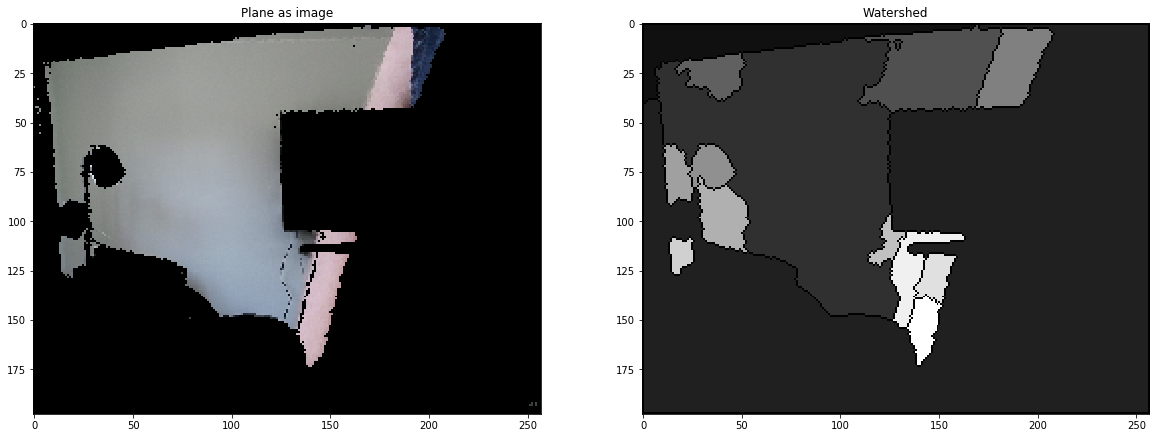

In [39]:
fig, subs = plt.subplots(1, 2, figsize=(20, 8))
subs[0].imshow(im)
subs[0].set_title("Plane as image")
subs[1].imshow(ws_res, cmap='gray')
subs[1].set_title("Watershed")

A list of the planes we found, and the amount of elements in each.

In [27]:
unique, counts = np.unique(ws_res, return_counts=True)
#counts, uniques = zip(*sorted(zip(counts, uniques), reverse=True))

print(counts)
print(unique)

[ 2162  1725 30435 10289     6  2078   480   947   333   306   623   168
   157   308   525   344]
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16]


A HSV version of the image

In [28]:
im_hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

Find set from watershed, that has colors that match.

In [29]:
good_vals = []
for u in unique:
    mean_h = np.mean(im_hsv[:,:,0][ws_res==u])
    mean_s = np.mean(im_hsv[:,:,1][ws_res==u])
    mean_v = np.mean(im_hsv[:,:,2][ws_res==u])
    print("For val {}  --  mean h: {}, mean s: {}, mean v: {}".format(u, mean_h, mean_s, mean_v))
    
    #if mean_h > 20 and mean_h < 70:
    #    good_vals.append(u)
    
    if mean_s < 20 and mean_v > 120:
        good_vals.append(u)

For val 0  --  mean h: 50.711840888066604, mean s: 16.372802960222018, mean v: 79.05596669750231
For val 1  --  mean h: 0.2371014492753623, mean s: 0.058550724637681156, mean v: 0.5339130434782609
For val 2  --  mean h: 0.2709380647281091, mean s: 0.07238376868736651, mean v: 0.34877608017085593
For val 3  --  mean h: 77.08475070463602, mean s: 18.24764311400525, mean v: 162.2284964525221
For val 4  --  mean h: 39.833333333333336, mean s: 11.833333333333334, mean v: 148.16666666666666
For val 5  --  mean h: 36.73195380173244, mean s: 9.974013474494706, mean v: 142.6655437921078
For val 6  --  mean h: 51.479166666666664, mean s: 10.445833333333333, mean v: 138.14375
For val 8  --  mean h: 147.18268215417106, mean s: 66.25131995776135, mean v: 151.43928194297783
For val 9  --  mean h: 3.6366366366366365, mean s: 0.6036036036036037, mean v: 6.3003003003003
For val 10  --  mean h: 60.22875816993464, mean s: 12.526143790849673, mean v: 132.23856209150327
For val 11  --  mean h: 79.449438202

And the good sets are

In [30]:
print(good_vals)

[3, 4, 5, 6, 10, 11, 13]


Generate a range of colors, used for visualization.

In [31]:
# https://www.quora.com/How-do-I-generate-n-visually-distinct-RGB-colours-in-Python
import colorsys
 
def HSVToRGB(h, s, v):
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v)
    return (int(255*r), int(255*g), int(255*b))
 
def getDistinctColors(n):
    huePartition = 1.0 / (n + 1)
    return (HSVToRGB(huePartition * value, 1.0, 1.0) for value in range(0, n))

Text(0.5,1,'Watershed regions with acceptable color')

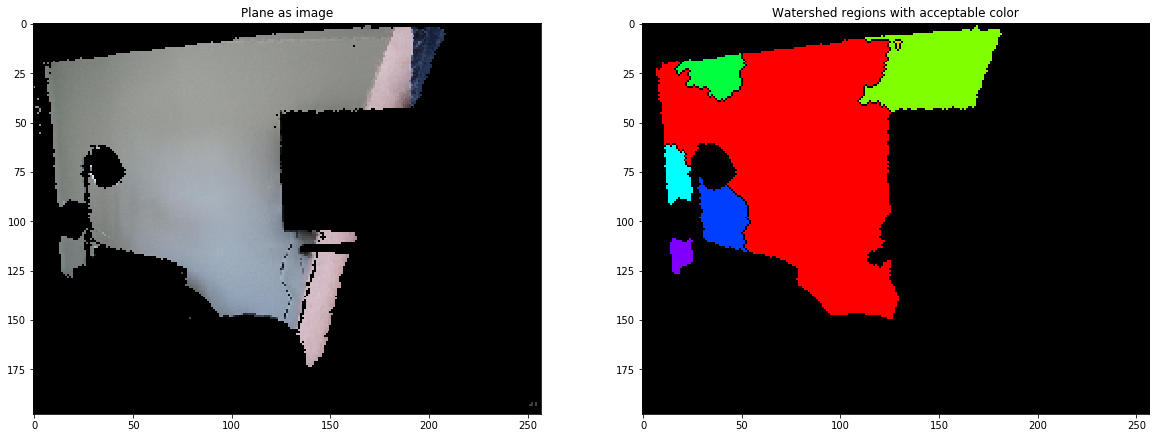

In [41]:
f, subs = plt.subplots(1, 2, figsize=(20, 10))

ws_res_color = np.zeros((ws_res.shape[0], ws_res.shape[1], 3), dtype=np.uint8)
colors = getDistinctColors(len(good_vals))

for g in good_vals:
    ws_res_color[ws_res==g] = next(colors)

subs[0].imshow(im)
subs[0].set_title("Plane as image")
subs[1].imshow(ws_res_color)
subs[1].set_title("Watershed regions with acceptable color")

### This is as far as I've gotten. Rest of

In [33]:
ws_res_color = np.zeros((ws_res.shape[0], ws_res.shape[1], 3), dtype=np.uint8)

In [34]:
val = unique[3]
print(val)
ws_res_color[ws_res==val] = (0, 0, 255)

3


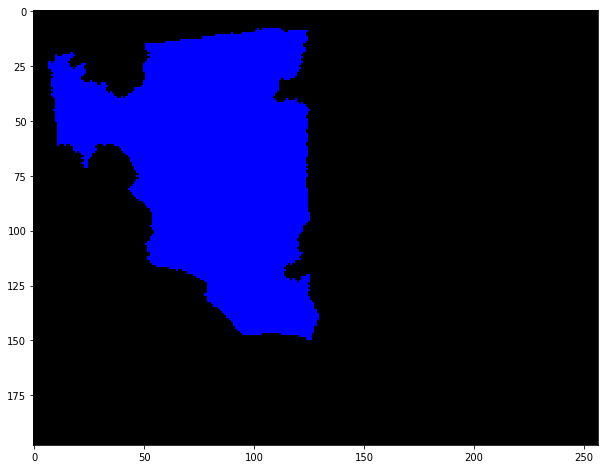

In [35]:
fig = plt.figure(figsize=(15, 8))
plt.imshow(ws_res_color)